Data Import
We used the titanic3 dataset sourced from https://hbiostat.org/data/
Data documentation: https://hbiostat.org/data/repo/Ctitanic3.html 

Data Cleaning 
The boat field has a few entries with multiple boat numbers such as '5 7' or 'C D'. After reviewing the data, entries with '5 7', 'C D', and '13 15' were entries of married couples. We made the assumption that the couple was split between two lifeboats and updated the data, randomly choosing which passenger received which boat number (e.g., for a married couple with entry '5, 7' we allocated Mrs -> 5; Mr -> 7). There were two entries with '13 15' and one entry with '13 15 B' in the boat field. We made the assumption that one of these individuals was on each of the boats 13, 15, and B, and allocated this randomly. For the rest of the multiple boat numbers '5 9', '8 10' and '15 16' there was only one entry each, so we randomly selected a boat number for each of these indiduals from their listed boat numbers. 

Data Merge
We merged the titanic3 dataset with lifeboat data using the boat number as a primary key. This lifeboat data includes boat number, time of launch, and boat location (starboard or port). Lifeboat data was sourced from https://titanicfacts.net/titanic-lifeboats/. Lifeboat capacity data was sourced from https://www.titanic-titanic.com/titanics-lifeboats/. 


In [ ]:
# All the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

# Read the titanic data and turn it into a dataframe
t = pd.read_csv('titanic3data.csv')

In [283]:
# Merging lifeboat data and checking how the output looks 
boats = pd.read_csv('lifeboat_data.csv')
titanic_cleaned = pd.merge(t, boats, on="boat", how='left')
titanic_cleaned.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,boat_loc,boat_deploy_time,capacity
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",port,1:45,40.0
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",starboard,1:35,65.0
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",NaN,NaN,NaN
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",NaN,NaN,NaN
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",NaN,NaN,NaN


In [284]:
# Cleaning boat locations with dupe entries in the same line
t.loc[292,"boat"]='5'
t.loc[293,"boat"]='7'
t.loc[820,"boat"]='C'
t.loc[823,"boat"]='D'
t.loc[1238,"boat"]='13'
t.loc[1277,"boat"]='15'
t.loc[86, "boat"]='5'
t.loc[315,"boat"]='10'
t.loc[746,"boat"]='B'
t.loc[999,"boat"]='16'

In [285]:
# Checking boat location values after data cleaning
t.boat.value_counts()

13    40
C     39
15    38
14    33
4     31
10    30
5     29
3     26
9     25
11    25
16    24
7     24
8     23
D     21
6     20
12    19
2     13
A     11
B     10
1      5
Name: boat, dtype: int64

In [286]:
# Calculate means to make sure code is working correctly
# titanic_cleaned[(titanic_cleaned.age.notna()) & (titanic_cleaned.pclass==3)].age.mean()
# pclass 1 age mean is 39.15992957746479 or 39.16
# pclass 2 age mean is 29.506704980842912 or 29.51
# pclass 3 age mean is 24.81636726546906 or 24.82

# Checking which rows of age are null to check later
# titanic_cleaned[titanic_cleaned.age.isnull()]
# check iloc 15, 37, 40, 46 are pclass 1, should be 39.16; iloc 1293, 1297, 1302, 1305 should be 24.82

# Replacing the one fare nan by the mean of the passenger's pclass (3) fare mean of 13.302888700564957 or 13.30
titanic_cleaned[(titanic_cleaned.fare.notna()) & (titanic_cleaned.pclass==3)].fare.mean()
titanic_cleaned.fare.fillna(13.30, inplace=True)

# Replacing age nans by the mean of each passenger's pclass
titanic_cleaned['age'] = titanic_cleaned.groupby('pclass')['age'].transform(lambda x: x.fillna(x.mean()))
# titanic_cleaned.head(20)
# titanic_cleaned.isnull().sum()
# titanic_cleaned[(titanic_cleaned.age.notna()) & (titanic_cleaned.pclass==1)].age.mean()

# Checks that it all went smoothly for nan replacements
# titanic_cleaned.iloc[[15]]
# titanic_cleaned.iloc[[37]]
# titanic_cleaned.iloc[[1293]]
# titanic_cleaned.iloc[[1305]]

# Round all babies between 0 and 1 up to 1 year of age
titanic_cleaned.loc[titanic_cleaned.age < 1, 'age'] = 1

# Replace all males with 0 and females with 1 for the heatmap
titanic_cleaned['sex'].replace('male', 0, inplace=True)
titanic_cleaned['sex'].replace('female', 1, inplace=True)
titanic_cleaned['family'] = (titanic_cleaned.sibsp+titanic_cleaned.parch)
titanic_cleaned.head()

# Drop Cabin, Body, Ticket, Home.dest columns
titanic_cleaned.drop('cabin', axis=1, inplace=True)
titanic_cleaned.drop('body', axis=1, inplace=True)
titanic_cleaned.drop('ticket', axis=1, inplace=True)
titanic_cleaned.drop('home.dest', axis=1, inplace=True)
# titanic_cleaned.head()

# Add a child_woman_man column 
conditions = [
    (titanic_cleaned["age"] < 13) & (titanic_cleaned["sex"] == 0),
    (titanic_cleaned["age"] < 18) & (titanic_cleaned["sex"] == 1),
    (titanic_cleaned["age"] >= 13) & (titanic_cleaned["sex"] == 0),
    (titanic_cleaned["age"] >= 18) & (titanic_cleaned["sex"] == 1)]
choices = ["child", "child", "man", "woman"]
titanic_cleaned["child_woman_man"] = np.select(conditions, choices, default = "None")

# Check nulls
titanic_cleaned.isnull().sum()

# # Save titanic_cleaned to CSV for use
titanic_cleaned = titanic_cleaned.copy(deep=True)
titanic_cleaned.to_csv('titanic_cleaned.csv')

man      793
woman    394
child    122
Name: child_woman_man, dtype: int64

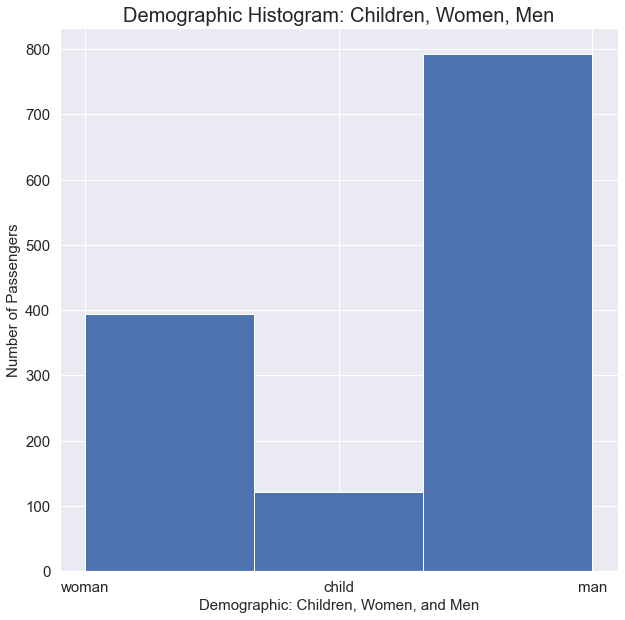

In [287]:
# Make child_woman_man histogram for 'Basic Characteristics of Titanic Data'
titanic_cleaned.child_woman_man.hist(bins=3)
plt.yticks(fontsize=15)
plt.ylabel("Number of Passengers", fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Demographic: Children, Women, and Men", fontsize=15)
plt.title("Demographic Histogram: Children, Women, Men", fontsize=20)

titanic_cleaned.child_woman_man.value_counts()



24.816367    208
24.000000     47
22.000000     43
21.000000     41
30.000000     40
            ... 
67.000000      1
23.500000      1
80.000000      1
22.500000      1
26.500000      1
Name: age, Length: 94, dtype: int64

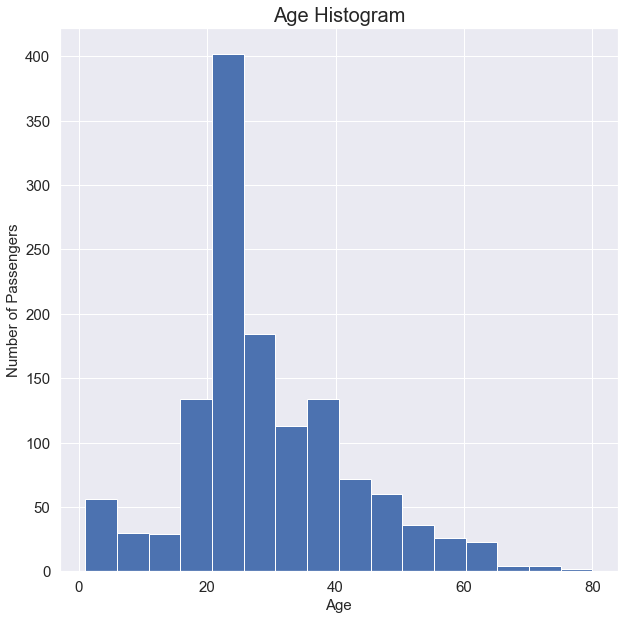

In [288]:
# Make age histogram for 'Basic Characteristics of Titanic Data'
titanic_cleaned.age.hist(bins=16)
plt.yticks(fontsize=15)
plt.ylabel("Number of Passengers", fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Age", fontsize=15)
plt.title("Age Histogram", fontsize=20)

titanic_cleaned.age.value_counts()

3    709
1    323
2    277
Name: pclass, dtype: int64

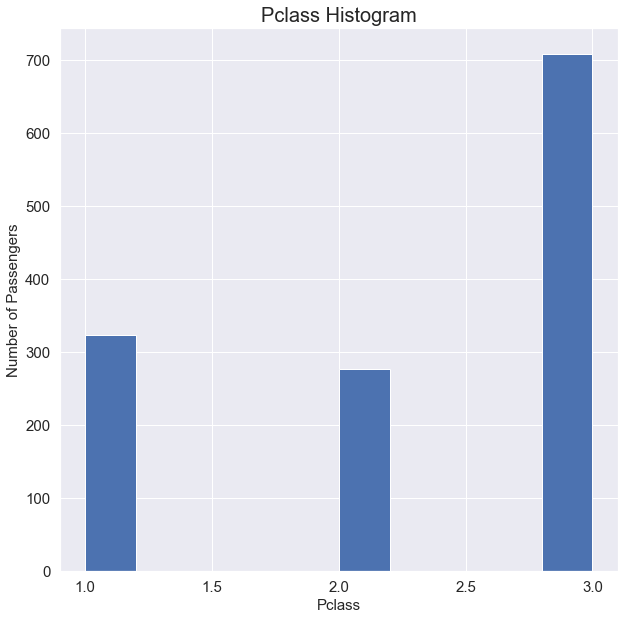

In [289]:
# Make pclass histogram for 'Basic Characteristics of Titanic Data'
titanic_cleaned.pclass.hist()
plt.yticks(fontsize=15)
plt.ylabel("Number of Passengers", fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Pclass", fontsize=15)
plt.title("Pclass Histogram", fontsize=20)

titanic_cleaned.pclass.value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

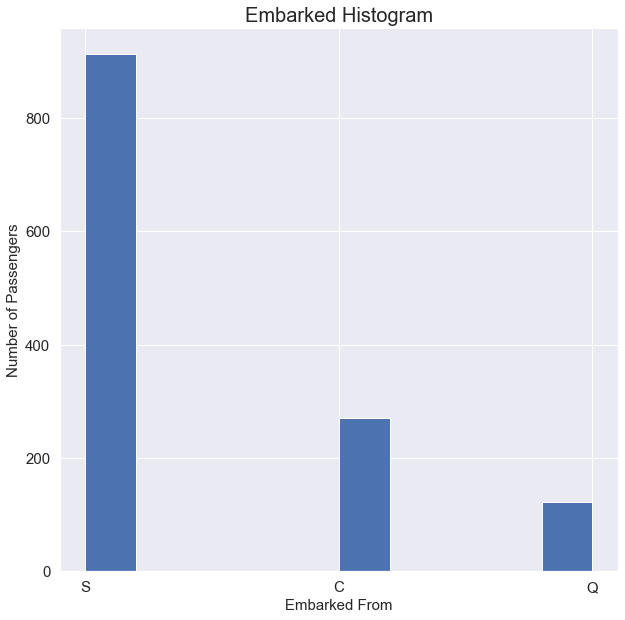

In [290]:
# Make embarked histogram for 'Basic Characteristics of Titanic Data'
titanic_cleaned.embarked.hist()
plt.yticks(fontsize=15)
plt.ylabel("Number of Passengers", fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Embarked From", fontsize=15)
plt.title("Embarked Histogram", fontsize=20)

titanic_cleaned.embarked.value_counts()

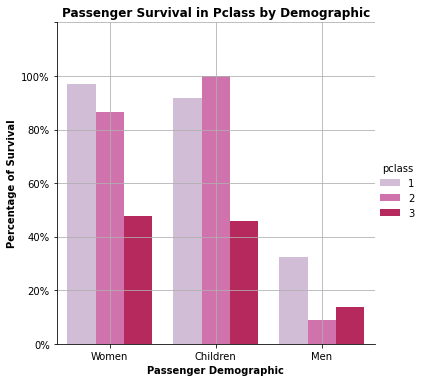

In [4]:
# Pclass Analysis 

conditions = [
    (titanic_cleaned["age"] < 13) & (titanic_cleaned["sex"] == 0),
    (titanic_cleaned["age"] < 18) & (titanic_cleaned["sex"] == 1),
    (titanic_cleaned["age"] >= 13) & (titanic_cleaned["sex"] == 0),
    (titanic_cleaned["age"] >= 18) & (titanic_cleaned["sex"] == 1)]
choices = ["Children", "Children", "Men", "Women"]
titanic_cleaned["child_female_male"] = np.select(conditions, choices, default = "None")

h = sns.catplot(x = "child_female_male", y = "survived", hue = "pclass", kind = "bar", data = titanic_cleaned, palette = "PuRd", ci = None)
plt.title("Passenger Survival in Pclass by Demographic", fontweight = "bold", size = 12)
plt.xlabel("Passenger Demographic", fontweight = "bold")
plt.ylabel("Percentage of Survival", fontweight = "bold")
h.set_yticklabels(("0%", "20%", "40%", "60%", "80%", "100%", ""))
plt.grid()
plt.show()

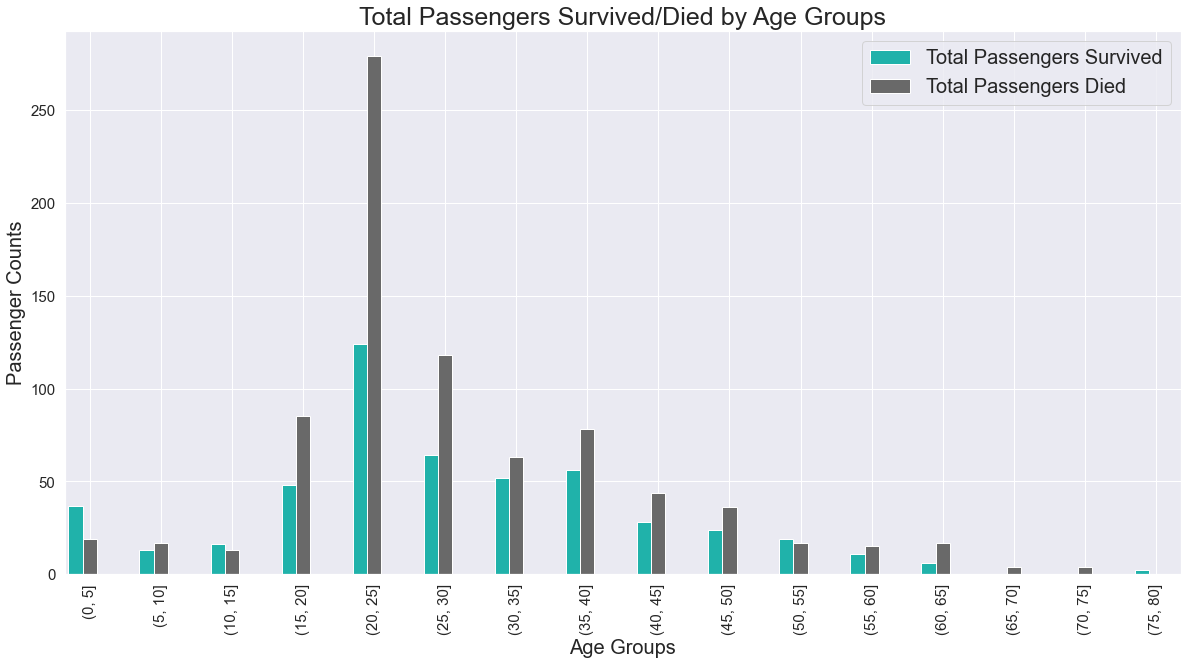

(20, 25]    279
(25, 30]    118
(15, 20]     85
(35, 40]     78
(30, 35]     63
(40, 45]     44
(45, 50]     36
(0, 5]       19
(5, 10]      17
(50, 55]     17
(60, 65]     17
(55, 60]     15
(10, 15]     13
(65, 70]      4
(70, 75]      4
(75, 80]      0
Name: age, dtype: int64
(20, 25]    124
(25, 30]     64
(35, 40]     56
(30, 35]     52
(15, 20]     48
(0, 5]       37
(40, 45]     28
(45, 50]     24
(50, 55]     19
(10, 15]     16
(5, 10]      13
(55, 60]     11
(60, 65]      6
(75, 80]      2
(65, 70]      0
(70, 75]      0
Name: age, dtype: int64


In [291]:
survived = titanic_cleaned[(titanic_cleaned.survived==1)]
passed = titanic_cleaned[(titanic_cleaned.survived==0)]
s_age_bins = pd.cut(survived.age, bins=range(0,85,5))
p_age_bins = pd.cut(passed.age, bins=range(0,85,5))

s_age_bins.value_counts(sort=False).plot.bar(stacked=True, width=0.2, position=1.5, color="lightseagreen", figsize=(20,10))
p_age_bins.value_counts(sort=False).plot.bar(stacked=False, width=0.2, position=0.5, color="dimgrey", figsize=(20,10))


plt.legend(["Total Passengers Survived", "Total Passengers Died"], fontsize=20)

plt.yticks(fontsize=15)
plt.ylabel("Passenger Counts", fontsize=20)
plt.xticks(fontsize=15)
plt.xlabel("Age Groups", fontsize=20)
plt.title("Total Passengers Survived/Died by Age Groups", fontsize=25)
# plt.grid(b=None)

plt.show()
print(p_age_bins.value_counts())
print(s_age_bins.value_counts())

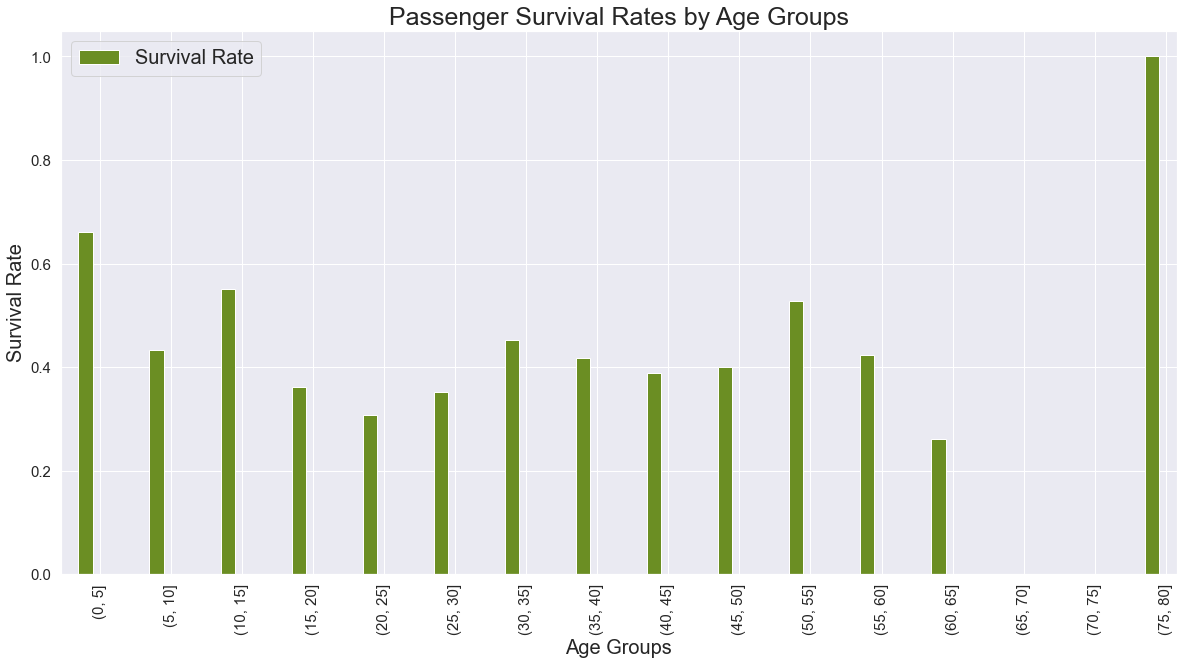

age_bins
(0, 5]      0.660714
(5, 10]     0.433333
(10, 15]    0.551724
(15, 20]    0.360902
(20, 25]    0.307692
(25, 30]    0.351648
(30, 35]    0.452174
(35, 40]    0.417910
(40, 45]    0.388889
(45, 50]    0.400000
(50, 55]    0.527778
(55, 60]    0.423077
(60, 65]    0.260870
(65, 70]    0.000000
(70, 75]    0.000000
(75, 80]    1.000000
Name: survived, dtype: float64

In [292]:
survival_rate = titanic_cleaned.copy(deep=True)
survival_rate['age_bins'] = pd.cut(survival_rate.age, bins=range(0,85,5))
surv_rate_age = (survival_rate.groupby('age_bins').survived.sum())/(survival_rate.groupby('age_bins').survived.count())

surv_rate_age.plot.bar(stacked=False, width=0.2, position=1.5, color="olivedrab", figsize=(20,10))

plt.legend(["Survival Rate"], fontsize=20)

plt.yticks(fontsize=15)
plt.ylabel("Survival Rate", fontsize=20)
plt.xticks(fontsize=15)
plt.xlabel("Age Groups", fontsize=20)
plt.title("Passenger Survival Rates by Age Groups", fontsize=25)
# plt.grid(b=None)
plt.show()

surv_rate_age

Columns missing from the heatmap include name, sex, ticket, cabin, embarked, boat, body, home.dest, capacity. This is due to nans or the fact that the values are strings. 

Since name, cabin, home dest, are more complicated strings, we won't try to make these into categoreis for correlation. We also aren't that interested in correlation of capacity, embarked, ticket, body.

We are also interested in sex, so in order to use it in the heatmap we will change sex to 1 for female and 0 for male.

For the missing values, we will in average age per pclass for null values
pclass 1 age mean is 39.15992957746479 or 39.16
pclass 2 age mean is 29.506704980842912 or 29.51
pclass 2 age mean is 24.81636726546906 or 24.82

There is only one null fare, which is a pclass 3 fare. We will replace it with the mean of a pclass 3 fare, which is 13.30. 

In [293]:
# checks for yujin's table
# len(titanic_cleaned[((titanic_cleaned.age<13)&(titanic_cleaned.survived==1)&(titanic_cleaned.sex=='male')&(titanic_cleaned.pclass==2))].index)/len(titanic_cleaned[((titanic_cleaned.age<13)&(titanic_cleaned.sex=='male')&(titanic_cleaned.pclass==2))].index)
# len(titanic_cleaned[((titanic_cleaned.age<13)&(titanic_cleaned.survived==1)&(titanic_cleaned.sex=='male')&(titanic_cleaned.pclass==2))].index)/len(titanic_cleaned[((titanic_cleaned.age<13)&(titanic_cleaned.sex=='male')&(titanic_cleaned.pclass==2))].index)
# len(titanic_cleaned[((titanic_cleaned.age<13)&(titanic_cleaned.survived==1)&(titanic_cleaned.pclass==2))].index)/len(titanic_cleaned[((titanic_cleaned.age<13)&(titanic_cleaned.pclass==1))].index)
# len(titanic_cleaned[((titanic_cleaned.age<13)&(titanic_cleaned.sex=='male')&(titanic_cleaned.survived==1)&(titanic_cleaned.pclass==2))].index)/len(titanic_cleaned[((titanic_cleaned.age<13)&(titanic_cleaned.pclass==3))].index)

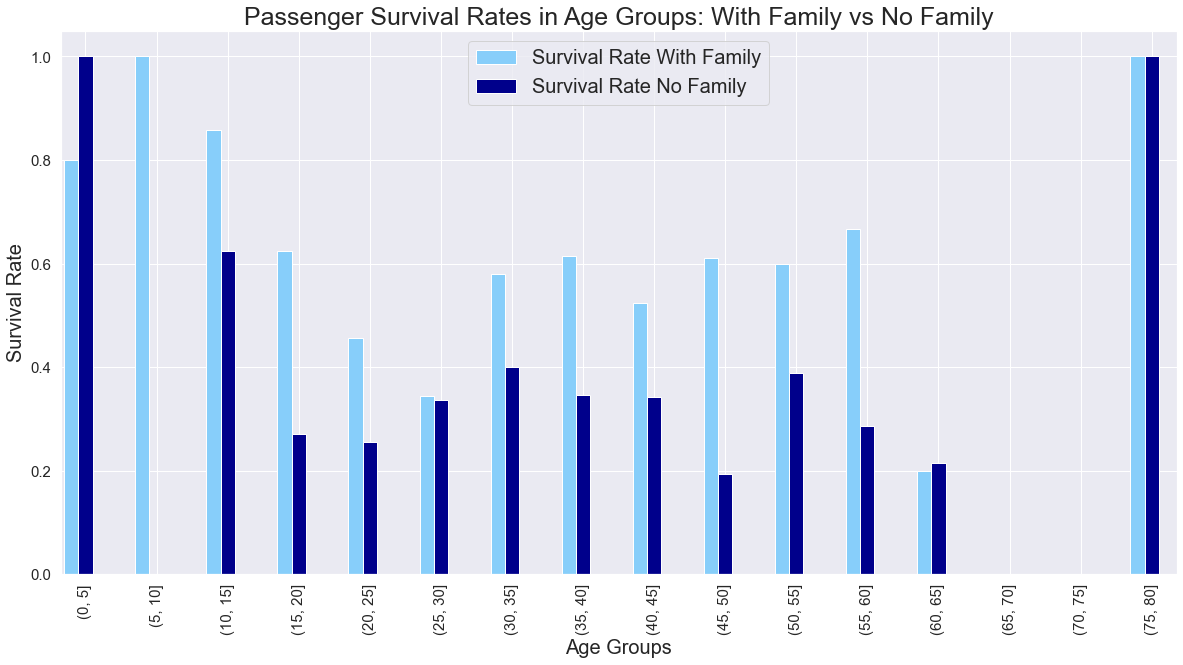

In [294]:
# Family Analysis

survival_rate_no_fam = (titanic_cleaned[(titanic_cleaned.family==0)]).copy(deep=True)
survival_rate_no_fam['no_fam_age_bins'] = pd.cut(survival_rate_no_fam.age, bins=range(0,85,5))
surv_no_fam = (survival_rate_no_fam.groupby('no_fam_age_bins').survived.sum())/(survival_rate_no_fam.groupby('no_fam_age_bins').survived.count())

survival_rate_with_fam = (titanic_cleaned[(titanic_cleaned.family==1)]).copy(deep=True)
survival_rate_with_fam['with_fam_age_bins'] = pd.cut(survival_rate_with_fam.age, bins=range(0,85,5))
surv_with_fam = (survival_rate_with_fam.groupby('with_fam_age_bins').survived.sum())/(survival_rate_with_fam.groupby('with_fam_age_bins').survived.count())

surv_with_fam.plot.bar(stacked=False, width=0.2, position=1.5, color="lightskyblue", figsize=(20,10))
surv_no_fam.plot.bar(stacked=False, width=0.2, position=0.5, color="darkblue", figsize=(20,10))

plt.legend(["Survival Rate With Family", "Survival Rate No Family"], fontsize=20)

plt.yticks(fontsize=15)
plt.ylabel("Survival Rate", fontsize=20)
plt.xticks(fontsize=15)
plt.xlabel("Age Groups", fontsize=20)
plt.title("Passenger Survival Rates in Age Groups: With Family vs No Family", fontsize=25)
# plt.grid(b=None)
plt.show()


# titanic_cleaned[(titanic_cleaned.survived==0) & (titanic_cleaned.family==0) & (titanic_cleaned.age<=15)]

# Y axis ticks to whole numbers % 

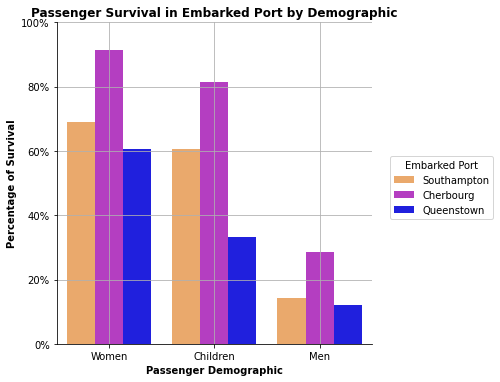

In [5]:
# Embarked Analysis 

g = sns.catplot(x = "child_female_male", y = "survived", hue = "embarked", kind = "bar", data = titanic_cleaned, palette = "gnuplot2_r", ci = None, legend= False)
plt.title("Passenger Survival in Embarked Port by Demographic", fontweight = "bold", size = 12)
plt.xlabel("Passenger Demographic", fontweight = "bold")
plt.ylabel("Percentage of Survival", fontweight = "bold")
g.set_yticklabels(("0%", "20%", "40%", "60%", "80%", "100%"))
L=plt.legend(bbox_to_anchor = (1.4, 0.6), title = "Embarked Port")
L.get_texts()[0].set_text("Southampton")
L.get_texts()[1].set_text("Cherbourg")
L.get_texts()[2].set_text("Queenstown")
plt.grid()
plt.show()

In [4]:
# All the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

# Read the titanic data and turn it into a dataframe
titanic_cleaned = pd.read_csv('/Users/Ekim/Downloads/project2/data/titanic_cleaned.csv')

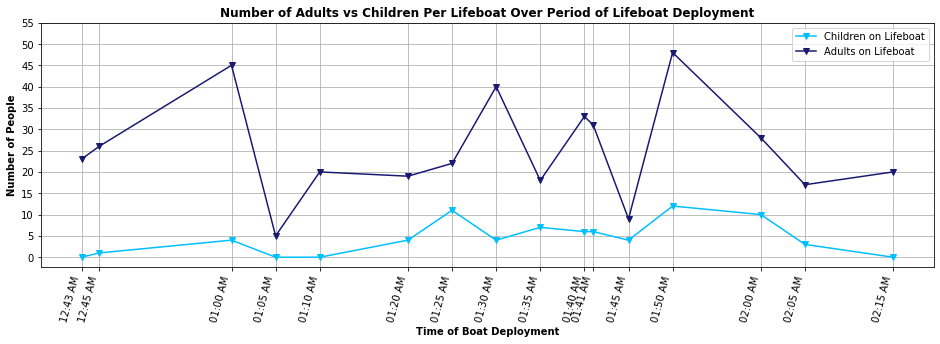

In [5]:
# Boat Deploy Time Analysis - Children vs Adults

conditions = [
    (titanic_cleaned["age"] < 13) & (titanic_cleaned["sex"] == 0),
    (titanic_cleaned["age"] < 18) & (titanic_cleaned["sex"] == 1),
    (titanic_cleaned["age"] >= 13) & (titanic_cleaned["sex"] == 0),
    (titanic_cleaned["age"] >= 18) & (titanic_cleaned["sex"] == 1)]
choices = ["Child", "Child", "Adult", "Adult"]
titanic_cleaned["child_adult"] = np.select(conditions, choices, default = "None")

titanic_children = titanic_cleaned.groupby("boat_deploy_time")["child_adult"].apply(lambda x: (x == "Child").sum()).reset_index()
titanic_children = pd.DataFrame(titanic_children)
titanic_children["boat_deploy_time"]= pd.to_datetime(titanic_children["boat_deploy_time"])
pd.DataFrame(titanic_children).set_index("boat_deploy_time")

titanic_adult = titanic_cleaned.groupby("boat_deploy_time")["child_adult"].apply(lambda x: (x == "Adult").sum()).reset_index()
titanic_adult = pd.DataFrame(titanic_adult)
titanic_adult["boat_deploy_time"]= pd.to_datetime(titanic_adult["boat_deploy_time"])
pd.DataFrame(titanic_adult).set_index("boat_deploy_time")

titanic_children_adult = pd.merge(titanic_children, titanic_adult, on = "boat_deploy_time")
titanic_children_adult = pd.DataFrame(titanic_children_adult)
titanic_children_adult["boat_deploy_time"]= pd.to_datetime(titanic_children_adult["boat_deploy_time"])
titanic_children_adult = pd.DataFrame(titanic_children_adult).set_index("boat_deploy_time")

titanic_children_adult.plot(marker = ("v"), figsize = (16, 5), color = ("deepskyblue", "midnightblue"))

plt.title("Number of Adults vs Children Per Lifeboat Over Period of Lifeboat Deployment", size = 12, fontweight = "bold")
plt.xlabel("Time of Boat Deployment", fontweight = "bold")
plt.ylabel("Number of People", fontweight = "bold")
plt.xticks(ticks = titanic_children_adult.index, rotation = 75, labels = titanic_children_adult.index.map(lambda x: datetime.datetime.strftime(x, "%I:%M %p")))
plt.yticks(np.arange(0, 60, step = 5))
plt.legend(edgecolor = "black")
L=plt.legend()
L.get_texts()[0].set_text("Children on Lifeboat")
L.get_texts()[1].set_text("Adults on Lifeboat")
plt.grid()
plt.show()

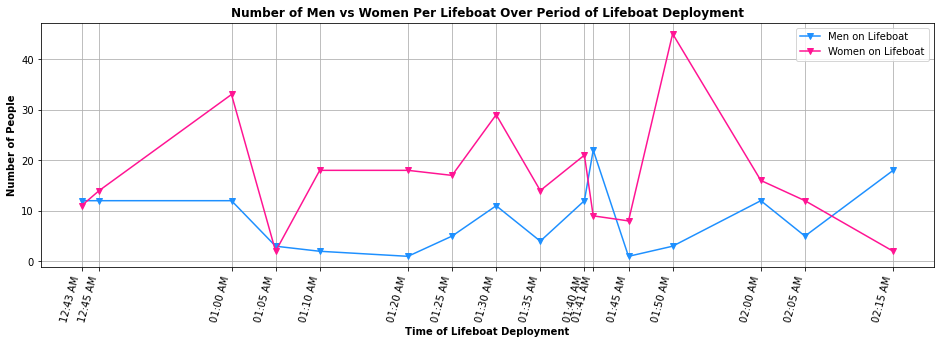

In [6]:
# Boat Deploy Time Analysis - Men vs Women

conditions = [
    (titanic_cleaned["age"] >= 13) & (titanic_cleaned["sex"] == 0),
    (titanic_cleaned["age"] >= 18) & (titanic_cleaned["sex"] == 1)]
choices = ["Adult Male", "Adult Female"]
titanic_cleaned["female_male"] = np.select(conditions, choices, default = "None")

titanic_male = titanic_cleaned.groupby("boat_deploy_time")["female_male"].apply(lambda x: (x == "Adult Male").sum()).reset_index()
titanic_male = pd.DataFrame(titanic_male)
titanic_male["boat_deploy_time"]= pd.to_datetime(titanic_male["boat_deploy_time"])
pd.DataFrame(titanic_male).set_index("boat_deploy_time")

titanic_female = titanic_cleaned.groupby("boat_deploy_time")["female_male"].apply(lambda x: (x == "Adult Female").sum()).reset_index()
titanic_female = pd.DataFrame(titanic_female)
titanic_female["boat_deploy_time"]= pd.to_datetime(titanic_female["boat_deploy_time"])
pd.DataFrame(titanic_female).set_index("boat_deploy_time")

titanic_female_male = pd.merge(titanic_male, titanic_female, on = "boat_deploy_time")
titanic_female_male = pd.DataFrame(titanic_female_male)
titanic_female_male["boat_deploy_time"]= pd.to_datetime(titanic_female_male["boat_deploy_time"])
titanic_female_male = pd.DataFrame(titanic_female_male).set_index("boat_deploy_time")

titanic_female_male.plot(marker = "v", figsize = (16, 5), color = ("dodgerblue", "deeppink"))
plt.title("Number of Men vs Women Per Lifeboat Over Period of Lifeboat Deployment", size = 12, fontweight = "bold")
plt.xlabel("Time of Lifeboat Deployment", fontweight = "bold")
plt.ylabel("Number of People", fontweight = "bold")
plt.xticks(ticks = titanic_female_male.index, rotation = 75, labels = titanic_female_male.index.map(lambda x: datetime.datetime.strftime(x, "%I:%M %p")))
plt.legend(edgecolor = "black")
L=plt.legend()
L.get_texts()[0].set_text("Men on Lifeboat")
L.get_texts()[1].set_text("Women on Lifeboat")
plt.grid()
plt.show()

In [ ]:
# Quick Calculation to Determine # of Children 
# Number of Children = 122 
titanic_cleaned.loc[titanic_cleaned["child_adult"] == "Child"]

# Quick Calculation to Determine # of Men 
# Number of Men = 793
titanic_cleaned.loc[titanic_cleaned["female_male"] == "Adult Male"]

# Quick Calculation to Determine # of Women 
# Number of Women = 394
titanic_cleaned.loc[titanic_cleaned["female_male"] == "Adult Female"]

In [8]:
titanic_children_male_female = pd.merge(titanic_children_adult, titanic_female_male, on = "boat_deploy_time")
titanic_children_male_female = titanic_children_male_female.drop(columns = ["child_adult_y"])
titanic_children_male_female = titanic_children_male_female.rename(columns = {"child_adult_x": "Number of Children on Lifeboat", "female_male_x": "Number of Men on Lifeboat", "female_male_y": "Number of Women on Lifeboat"})
Number_of_Children_Remaining_on_Titanic = [122, 121, 127, 127, 127, 123, 112, 108, 101 ,95, 89, 85, 73, 63, 60, 60]
titanic_children_male_female["Number of Children Remaining on Titanic Post Boat Deployal"] = Number_of_Children_Remaining_on_Titanic
Number_of_Women_Remaining_on_Titanic = [383, 369, 336, 334, 316, 298, 281, 252, 238, 217, 208, 200, 155, 139, 127, 125]
titanic_children_male_female["Number of Women Remaining on Titanic Post Boat Deployal"] = Number_of_Women_Remaining_on_Titanic
Number_of_Men_Remaining_on_Titanic = [781, 769, 757, 754, 752, 751, 746, 735, 731, 719, 697, 696, 693, 681, 676, 658]
titanic_children_male_female["Number of Men Remaining on Titanic Post Boat Deployal"] = Number_of_Men_Remaining_on_Titanic
times = titanic_children_male_female.index.map(lambda x: datetime.datetime.strftime(x, "%I:%M %p"))
titanic_children_male_female["Boat Deployal Times"] = times
titanic_children_male_female = pd.DataFrame(titanic_children_male_female)
titanic_children_male_female = titanic_children_male_female.reset_index()
titanic_children_male_female = titanic_children_male_female.drop(columns = ["boat_deploy_time"])
titanic_children_male_female.set_index("Boat Deployal Times")


,Number of Children on Lifeboat,Number of Men on Lifeboat,Number of Women on Lifeboat,Number of Children Remaining on Titanic Post Boat Deployal,Number of Women Remaining on Titanic Post Boat Deployal,Number of Men Remaining on Titanic Post Boat Deployal
Boat Deployal Times,,,,,,
12:43 AM,0,12,11,122,383,781
12:45 AM,1,12,14,121,369,769
01:00 AM,4,12,33,127,336,757
01:05 AM,0,3,2,127,334,754
01:10 AM,0,2,18,127,316,752
01:20 AM,4,1,18,123,298,751
01:25 AM,11,5,17,112,281,746
01:30 AM,4,11,29,108,252,735
01:35 AM,7,4,14,101,238,731


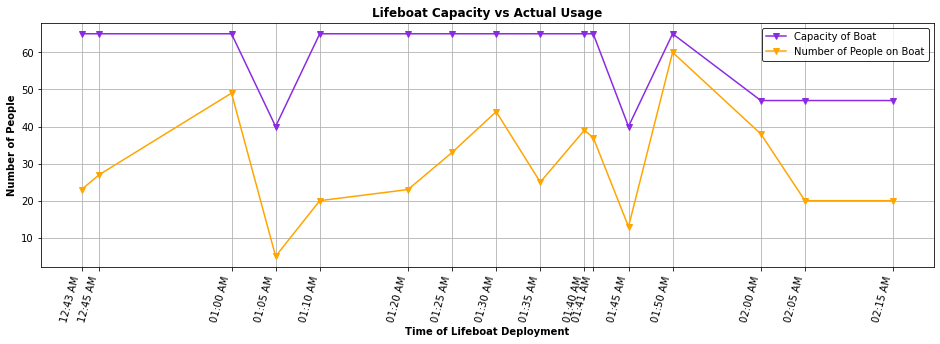

In [18]:
# Boat Deploy Time - Capacity vs. Body Count

titanic_capacity = titanic_cleaned.groupby("boat_deploy_time")["capacity"].mean().reset_index()
titanic_capacity = titanic_capacity.rename(columns = {"boat_deploy_time": "Boat Deploy Time", "capacity": "Capacity of Boat"})
pd.DataFrame(titanic_capacity).set_index(["Boat Deploy Time", "Capacity of Boat"])

titanic_onboard = titanic_cleaned.groupby("boat_deploy_time")["boat"].count().reset_index()
titanic_onboard = titanic_onboard.rename(columns = {"boat_deploy_time": "Boat Deploy Time", "boat": "Number of People on Boat"})
pd.DataFrame(titanic_onboard).set_index(["Boat Deploy Time", "Number of People on Boat"])

titanic_merged = pd.merge(titanic_capacity, titanic_onboard, on = "Boat Deploy Time")
titanic_merged = pd.DataFrame(titanic_merged)
titanic_merged["Boat Deploy Time"]= pd.to_datetime(titanic_merged["Boat Deploy Time"])
titanic_merged = pd.DataFrame(titanic_merged).set_index("Boat Deploy Time")

titanic_merged.plot(marker = "v", figsize = (16, 5), color = ("blueviolet", "orange"))

plt.title("Lifeboat Capacity vs Actual Usage", size = 12, fontweight = "bold")
plt.xlabel("Time of Lifeboat Deployment", fontweight = "bold")
plt.ylabel("Number of People", fontweight = "bold")
plt.xticks(ticks = titanic_merged.index, rotation = 75, labels = titanic_merged.index.map(lambda x: datetime.datetime.strftime(x, "%I:%M %p")))
plt.legend(edgecolor = "black")
plt.grid()
plt.show()

In [295]:
t_cols = ['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'family', 'fare']
col_corr_score = titanic_cleaned[t_cols].corr()
col_corr_score
# missing cols = name, sex, ticket, cabin, embarked, boat, body, home.dest, capacity

,pclass,survived,sex,age,sibsp,parch,family,fare
pclass,1.000000,-0.312469,-0.124617,-0.443715,0.060832,0.018322,0.050027,-0.558694
survived,-0.312469,1.000000,0.528693,-0.026575,-0.027825,0.082660,0.026876,0.244426
sex,-0.124617,0.528693,1.000000,-0.053291,0.109609,0.213125,0.188583,0.185693
age,-0.443715,-0.026575,-0.053291,1.000000,-0.198936,-0.130987,-0.202446,0.198384
sibsp,0.060832,-0.027825,0.109609,-0.198936,1.000000,0.373587,0.861952,0.160357
parch,0.018322,0.082660,0.213125,-0.130987,0.373587,1.000000,0.792296,0.221641
family,0.050027,0.026876,0.188583,-0.202446,0.861952,0.792296,1.000000,0.226617
fare,-0.558694,0.244426,0.185693,0.198384,0.160357,0.221641,0.226617,1.000000


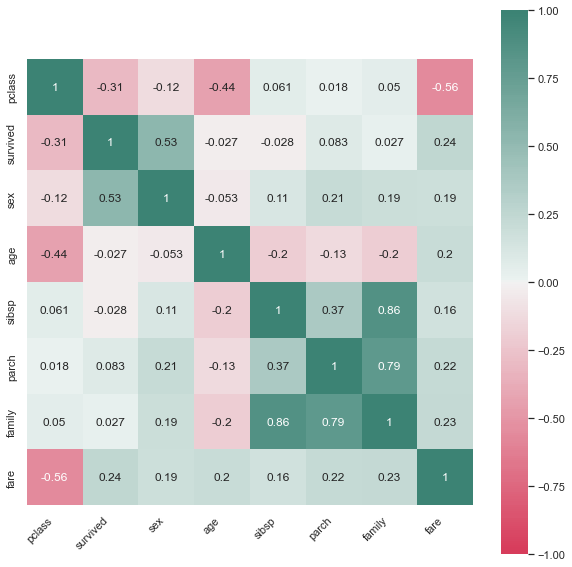

In [300]:
# Heatmap

ax = sns.heatmap(
    col_corr_score, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(5, 170, n=300),
    square=True,
    annot=True
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

sns.set(rc = {'figure.figsize':(10,10)}, font_scale=1)

/var/folders/sm/9yx6v57d1458gpt3v__q2vnm0000gn/T/ipykernel_4382/653800005.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


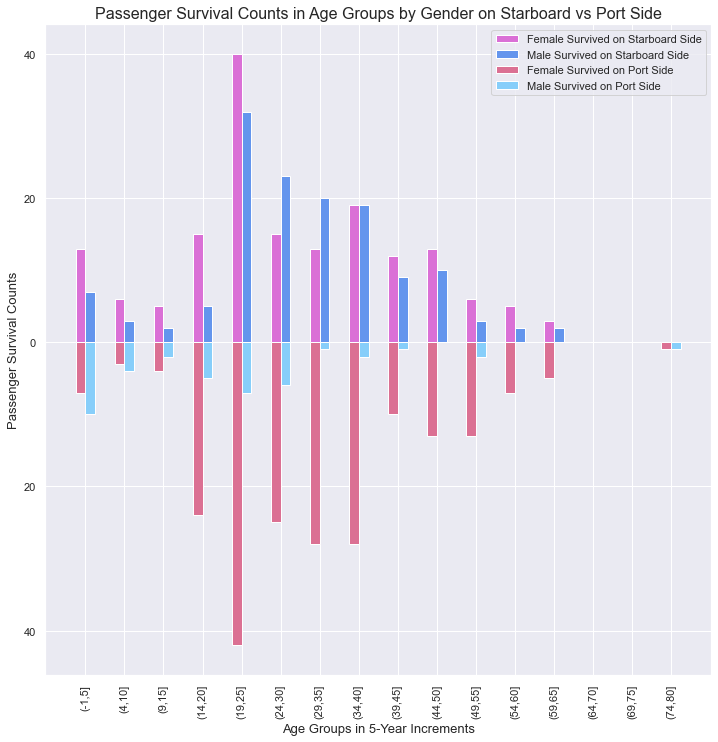

In [297]:
# Passenger Survival Counts by Starboard vs Port and Gender

y = ['({},{}]'.format(i-1, i+5) for i in range(0, 80, 5)]
def get_age_range_count(df):
    age_counts = []
    for i in range(0, 80, 5):
        age_counts.append(len(df[df['age'].between(i,i+5)]))
    return age_counts

starboard_f = titanic_cleaned[((titanic_cleaned.survived==1)&(titanic_cleaned.boat_loc=='starboard')&(titanic_cleaned.sex==1))][['age', 'sex', 'boat_loc']]
starboard_m = titanic_cleaned[((titanic_cleaned.survived==1)&(titanic_cleaned.boat_loc=='starboard')&(titanic_cleaned.sex==0))][['age', 'sex', 'boat_loc']]
port_f = titanic_cleaned[((titanic_cleaned.survived==1)&(titanic_cleaned.boat_loc=='port')&(titanic_cleaned.sex==1))][['age', 'sex', 'boat_loc']]
port_m = titanic_cleaned[((titanic_cleaned.survived==1)&(titanic_cleaned.boat_loc=='port')&(titanic_cleaned.sex==0))][['age', 'sex', 'boat_loc']]
neg_port_f = [ -x for x in get_age_range_count(port_f)]
neg_port_m = [ -x for x in get_age_range_count(port_m)]

fig, ax = plt.subplots()

ax.bar(y, get_age_range_count(starboard_f), align='edge', width=-0.25, color = 'orchid')
ax.bar(y, get_age_range_count(starboard_m), align='edge', width=0.25, color= 'cornflowerblue')
ax.bar(y, neg_port_f,align='edge', width=-0.25, color='palevioletred')
ax.bar(y, neg_port_m,align='edge', width=0.25, color='lightskyblue')


# Formatting x labels
plt.xticks(rotation=90)
plt.tight_layout()
# Use absolute value for y-ticks
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
ax.legend(['Female Survived on Starboard Side', 'Male Survived on Starboard Side', 'Female Survived on Port Side', 'Male Survived on Port Side'])
ax.set_xlabel("Age Groups in 5-Year Increments", fontsize=13)
ax.set_ylabel("Passenger Survival Counts", fontsize=13)
ax.set_title("Passenger Survival Counts in Age Groups by Gender on Starboard vs Port Side", fontsize=16)
plt.show()